In [1]:
from pyspark.sql import SparkSession
import numpy as np
import pandas as pd
from pyspark.sql import DataFrame
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
from datetime import date

sns.set()
pd.options.display.max_columns = None

%matplotlib inline

In [2]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Load data") \
    .config("spark.driver.memory", "4G") \
    .config("spark.sql.execution.arrow.enabled", "false") \
    .getOrCreate()

In [3]:
import os

HOME = os.environ["HOME"]
dataRoot = os.path.join(HOME, "Dropbox", "LobsterOnSpark")
messageRootDir = os.path.join(dataRoot, "message")
orderBookRootDir = os.path.join(dataRoot, "orderBook", "level=10")


In [4]:
messageDf = spark.read.parquet(messageRootDir)
orderBookDf = spark.read.parquet(orderBookRootDir)

In [5]:
messageDf.limit(5).toPandas().head()

,time,eventType,sequenceNumber,orderId,side,effectiveQuantity,effectivePrice,attribution,matchNumber,date,symbol
0,14409560325104,Submission,550,107957,Buy,1,464000,,0,2020-02-03,AMD
1,14411371520116,Submission,560,108553,Buy,100,467400,,0,2020-02-03,AMD
2,14411500320933,Submission,570,108629,Sell,100,472100,,0,2020-02-03,AMD
3,14412613952344,Submission,580,108825,Sell,1,528000,,0,2020-02-03,AMD
4,14412934478850,Submission,590,108913,Buy,3,450000,,0,2020-02-03,AMD


In [6]:
orderBookDf.limit(5).toPandas().head()

,sequenceNumber,timestamp,Bid_10_price,Bid_10_quantity,Bid_1_price,Bid_1_quantity,Bid_2_price,Bid_2_quantity,Bid_3_price,Bid_3_quantity,Bid_4_price,Bid_4_quantity,Bid_5_price,Bid_5_quantity,Bid_6_price,Bid_6_quantity,Bid_7_price,Bid_7_quantity,Bid_8_price,Bid_8_quantity,Bid_9_price,Bid_9_quantity,Offer_10_price,Offer_10_quantity,Offer_1_price,Offer_1_quantity,Offer_2_price,Offer_2_quantity,Offer_3_price,Offer_3_quantity,Offer_4_price,Offer_4_quantity,Offer_5_price,Offer_5_quantity,Offer_6_price,Offer_6_quantity,Offer_7_price,Offer_7_quantity,Offer_8_price,Offer_8_quantity,Offer_9_price,Offer_9_quantity,date,symbol
0,13375900,4.540860e+13,476400.0,1300.0,476300.0,2501.0,475800.0,900.0,475900.0,1402.0,475600.0,715.0,476500.0,700.0,476000.0,750.0,475700.0,1493.0,476200.0,2327.0,476100.0,1850.0,476600.0,1500.0,477100.0,1332.0,476700.0,1300.0,477300.0,1813.0,477500.0,1393.0,477200.0,1784.0,477000.0,1340.0,476800.0,1210.0,477400.0,2193.0,476900.0,1938.0,2020-02-03,AMD
1,12421330,4.422382e+13,475300.0,1993.0,475100.0,895.0,475800.0,1400.0,475900.0,844.0,475600.0,1721.0,476000.0,307.0,475700.0,2100.0,475500.0,1300.0,475400.0,1693.0,475200.0,953.0,476600.0,2353.0,476300.0,2600.0,476700.0,1694.0,476500.0,5872.0,476200.0,1200.0,477000.0,4429.0,476100.0,1910.0,476400.0,1200.0,476800.0,2093.0,476900.0,828.0,2020-02-03,AMD
2,6358840,3.902724e+13,471400.0,602.0,470800.0,1053.0,470600.0,1444.0,470700.0,1696.0,471100.0,1123.0,471200.0,1300.0,470900.0,2175.0,470500.0,2013.0,471000.0,5207.0,471300.0,1406.0,471900.0,1218.0,471800.0,2100.0,471500.0,3666.0,472000.0,9756.0,471700.0,2154.0,472100.0,1436.0,472200.0,3436.0,472400.0,900.0,472300.0,1336.0,471600.0,1143.0,2020-02-03,AMD
3,10190690,4.219795e+13,474900.0,1407.0,474800.0,2243.0,475100.0,700.0,474300.0,1513.0,474500.0,1796.0,474700.0,900.0,474600.0,3347.0,475000.0,1175.0,474400.0,1501.0,475200.0,2300.0,475400.0,2036.0,476300.0,1113.0,475800.0,1604.0,475900.0,1526.0,475600.0,2400.0,476000.0,5094.0,475700.0,900.0,476200.0,793.0,475500.0,3400.0,476100.0,1416.0,2020-02-03,AMD
4,16914430,4.956470e+13,478800.0,100.0,477900.0,700.0,478200.0,710.0,478300.0,1200.0,478000.0,694.0,478700.0,1200.0,478400.0,1250.0,478100.0,3805.0,478500.0,3610.0,478600.0,2300.0,479600.0,1368.0,478900.0,2412.0,479700.0,830.0,479300.0,1318.0,479000.0,11000.0,479400.0,1411.0,479200.0,2318.0,479100.0,1218.0,479800.0,1293.0,479500.0,843.0,2020-02-03,AMD


In [7]:
symbol='AMZN'

myDate=date(2020,2,3)
myDateStr = myDate.strftime('%Y-%m-%d')
myOrders = messageDf.where(f"date='{myDateStr}' and symbol='{symbol}'")
myOrderbooks = orderBookDf.where(f"date='{myDateStr}' and symbol='{symbol}'")

In [10]:
myOrders.where("eventType='Submission' and not (attribution='')") \
.groupBy("attribution").count().toPandas() \
.sort_values("count", ascending=False).head(10)

,attribution,count
1,IMCC,41601
16,UBSS,3153
30,GSCO,22
28,SGAS,16
3,SSUS,12
19,ETMM,12
7,SUFI,12
22,MSCO,10
13,OHOS,10
42,TSSM,10


In [12]:
myMPIDOrders = myOrders.where("attribution in ('IMCC', 'UBSS')").toPandas()

In [13]:
myMPIDOrders.loc[(myMPIDOrders['eventType'] != 'Submission'), 'effectiveQuantity'] = \
    - myMPIDOrders.loc[(myMPIDOrders['eventType'] != 'Submission'), 'effectiveQuantity'] 

grouped = myMPIDOrders.groupby(["effectivePrice","attribution"])

In [14]:
MPIDPositions = pd.DataFrame()
for name, group in grouped:
    price, mpid = name
    timeQuantity = group.loc[:, ['time', 'effectiveQuantity']].sort_values("time")
    timeQuantity['remainingQuantity'] = timeQuantity['effectiveQuantity'].cumsum()
    timeQuantity['price'] = price
    timeQuantity['mpid'] = mpid
    MPIDPositions = pd.concat([MPIDPositions, timeQuantity], axis=0)


In [15]:
MPIDPositions['timestamp'] = pd.to_timedelta(MPIDPositions['time']/1e9, unit='s') + pd.to_datetime(myDate)
MPIDPositions = MPIDPositions.loc[(MPIDPositions['time']>34200*1e9)&(MPIDPositions['time']<16*3600*1e9),:]

In [16]:
MPIDPositions['price'].quantile([0.01, 0.99])

0.01    17107600.0
0.99    22003848.0
Name: price, dtype: float64

/home/ruihong/.conda/envs/spark_python/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


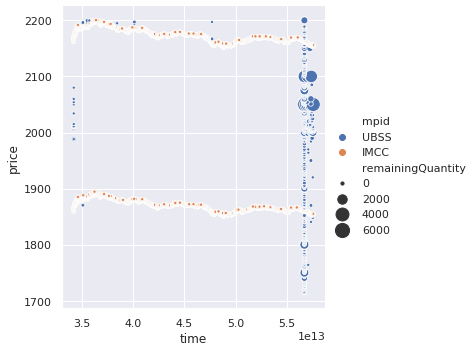

In [24]:
cleanedMPIDPositions = MPIDPositions.loc[(MPIDPositions['price']>17107600) &(MPIDPositions['price']<22003848), : ]
cleanedMPIDPositions['price'] = cleanedMPIDPositions['price'] / 10000
g=sns.relplot(x="time", y="price", size="remainingQuantity", hue='mpid', sizes=(10,200), data=cleanedMPIDPositions)
